In [ ]:
import os
with open(os.path.abspath("../data/obsdim5_statedim50_out.txt"), "r") as outfile:
	sequence = outfile.read()
print(sequence[:100], end='[...]\n')

In [ ]:
import pandas as pd
possible_observations_est = list(pd.Series(list(sequence)).drop_duplicates().sort_values())
possible_observations_est

In [ ]:
import re

def count_appearences(
	observation,
	*subwords
) -> int:
	word = "".join(subwords)
	pattern = "(?=(" + word + "))"
	count = len(re.findall(pattern, observation))
	return count

In [ ]:
maxlen = 6
words = ['']
freqs = []

for wlen in range(1, maxlen + 1):
    cur_nwords = len(words)

    for idx, word in enumerate(words):
        if idx >= cur_nwords:
            break

        for obs in possible_observations_est:
            new_word = word + obs
            appearences = count_appearences(sequence, new_word)

            if appearences > 0:
                words.append(word + obs)
                freqs.append(appearences)
    
    try:
        words.remove('')
    except ValueError:
        pass

wds = pd.DataFrame({
    "word": words,
    "freq": freqs
})
wds = wds.sort_values(by = "freq", ascending = False).reset_index(drop = True)
wds["cum_prop"] = wds["freq"].cumsum() / wds["freq"].sum()

In [ ]:
par = 3000 # len(wds.index)
cutoff = 0.50

wds_trim = wds[wds["cum_prop"] <= cutoff]

from matplotlib import pyplot as plt
from matplotlib import ticker as mtick

fig, ax = plt.subplots(figsize = (4, 3), layout = "constrained")
ax.plot(wds.index[:par+1], wds["cum_prop"][:par+1], c = 'k')
ax.axhline(y = wds["cum_prop"][par+1], ls = '--', c = 'r')
ax.set_xlim([0, par])
ax.set_ylim([0, 1])
ax.set_xlabel("Word index (sorted by descending count)")
ax.set_ylabel("Cumulative proportion (%)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.show()

print(f"Keeping {100*par/len(wds.index):<.2f}% of words accounts for "
      f"{100*wds["cum_prop"][par+1]:<.2f}% of counted substrings (with overlap)")

print(f"Keeping {100*len(wds_trim)/len(wds.index):<.2f}% of words accounts for "
      f"{100*cutoff:<.2f}% of counted substrings (with overlap)")

# Code

In [292]:
import re

def count_appearences(
	observation,
	*subwords
) -> int:
	word = "".join(subwords)
	pattern = "(?=(" + word + "))"
	count = len(re.findall(pattern, observation))
	return count


def get_most_common(
    observation,
    maxlen,
    cutoff = 1.0,
    possible_observations = None
):
    if possible_observations is None:
        possible_observations_est = list(pd.Series(list(observation)).drop_duplicates().sort_values())
    else:
        possible_observations_est = possible_observations
    
    words = ['']
    freqs = []
    
    for wlen in range(1, maxlen + 1):
        cur_nwords = len(words)
    
        for idx, word in enumerate(words):
            if idx >= cur_nwords:
                break
    
            for obs in possible_observations_est:
                new_word = word + obs
                if new_word in words:
                    continue
                
                appearences = count_appearences(observation, new_word)
    
                if appearences > 0:
                    words.append(word + obs)
                    freqs.append(appearences)
        
        try:
            words.remove('')
        except ValueError:
            pass
    
    wds = pd.DataFrame({
        "word": words,
        "freq": freqs
    })
    wds = wds.sort_values(by = "freq", ascending = False).reset_index(drop = True)
    wds["cum_prop"] = wds["freq"].cumsum() / wds["freq"].sum()
    
    wds_trim = wds[wds["cum_prop"] <= cutoff]
    
    print(f"Keeping {100*len(wds_trim)/len(wds.index):<.2f}% of words accounts for "
          f"{100*cutoff:<.2f}% of counted substrings (with overlap)")

    return wds_trim

In [320]:
def get_memory_usage_MB(
    n_observations,
    n_cwords,
    n_iwords = None
):
    if n_iwords is None:
        n_iwords = n_cwords
    
    def mat_memsize_bytes(n_rows, n_cols):
        # 8 bytes per entry
        # 128 bytes of machinery
        return 8 * n_rows * n_cols + 128
    
    # F_IJ and F_IzJ (for z in observations) => shape (n_words + 1) x (n_words + 1)
    mem_bigmats = (1 + n_observations) + mat_memsize_bytes(n_iwords + 1, n_cwords + 1)

    # F_0J and F_I0 => shape 1 x n_words, n_words x 1
    mem_rcvecs = mat_memsize_bytes(1, n_iwords) + mat_memsize_bytes(n_cwords, 1)

    # 1 MB = 10**6 bytes
    conv_fac = 10 ** 6
    
    return (mem_bigmats + mem_rcvecs) / conv_fac

In [321]:
def get_max_nwords(
    n_observations,
    maxlen
) -> int:
    n = n_observations
    k = maxlen
    return (n ** (k + 1) - 1) // (n - 1) - 1

In [295]:
import os

import pandas as pd
import numpy as np

### Comparing theory and practice

The following code loads sequences with increasing observation space sizes (i.e., $\vert\Sigma\vert = 2, 5, 20$ are the sizes of the finite alphabet) and compares the theoretical maximum number of words of length $l \leq \text{maxlen}$ to the actual count, where words with zero appearences are not considered. Luckily, even for $\text{maxlen} = 3$, the true number of occurences makes for a very low result in practice.

In [296]:
sequence2 = 5000 * 'abbabababb'
print("Sequence:", sequence2[:70], end='[...]\n')

possible_observations_est = list(pd.Series(list(sequence2)).drop_duplicates().sort_values())
n_obs = len(possible_observations_est)
print("Alphabet:", *possible_observations_est, f"(size {n_obs})", end='\n\n')

maxlen = 5
words_df2 = get_most_common(sequence2, maxlen = maxlen)

max_nwords = get_max_nwords(n_obs, maxlen)
true_nwords = len(words_df2)

print()
print(f"Max number of words: {max_nwords}")
print(f"Max memory usage: {get_memory_usage_MB(n_obs, max_nwords):<.3f} MB")
print()
print(f"Nonzero number of words: {true_nwords}")
print(f"Nonzero memory usage: {get_memory_usage_MB(n_obs, true_nwords):<.3f} MB")

Sequence: abbabababbabbabababbabbabababbabbabababbabbabababbabbabababbabbabababb[...]
Alphabet: a b (size 2)

Keeping 100.00% of words accounts for 100.00% of counted substrings (with overlap)

Max number of words: 62
Max memory usage: 0.033 MB

Nonzero number of words: 21
Nonzero memory usage: 0.005 MB


In [249]:
with open(os.path.abspath("../data/obsdim5_statedim50_out.txt"), "r") as outfile:
	sequence5 = outfile.read()
print("Sequence:", sequence5[:70], end='[...]\n')

possible_observations_est = list(pd.Series(list(sequence5)).drop_duplicates().sort_values())
n_obs = len(possible_observations_est)
print("Alphabet:", *possible_observations_est, f"(size {n_obs})", end='\n\n')

maxlen = 5
words_df5 = get_most_common(sequence5, maxlen = maxlen)

max_nwords = get_max_nwords(n_obs, maxlen)
true_nwords = len(words_df5)

print()
print(f"Max number of words: {max_nwords}")
print(f"Max memory usage: {get_memory_usage_MB(n_obs, max_nwords):<.3f} MB")
print()
print(f"Nonzero number of words: {true_nwords}")
print(f"Nonzero memory usage: {get_memory_usage_MB(n_obs, true_nwords):<.3f} MB")

Sequence: dbbeccceeedcaeddbccedadeebceedebeadbeaccaeccacebaaacdccebabdabdcaeddab[...]
Alphabet: a b c d e (size 5)

Keeping 100.00% of words accounts for 100.00% of counted substrings (with overlap)

Max number of words: 3905
Max memory usage: 122.118 MB

Nonzero number of words: 3905
Nonzero memory usage: 122.118 MB


In [250]:
with open(os.path.abspath("../data/obsdim20_statedim20_out.txt"), "r") as outfile:
	sequence20 = outfile.read()
print("Sequence:", sequence20[:70], end='[...]\n')

possible_observations_est = list(pd.Series(list(sequence20)).drop_duplicates().sort_values())
n_obs = len(possible_observations_est)
print("Alphabet:", *possible_observations_est, f"(size {n_obs})", end='\n\n')

maxlen = 5
words_df20 = get_most_common(sequence20, maxlen = maxlen)

max_nwords = get_max_nwords(n_obs, maxlen)
true_nwords = len(words_df20)

print()
print(f"Max number of words: {max_nwords}")
print(f"Max memory usage: {get_memory_usage_MB(n_obs, max_nwords):<.3f} MB")
print()
print(f"Nonzero number of words: {true_nwords}")
print(f"Nonzero memory usage: {get_memory_usage_MB(n_obs, true_nwords):<.3f} MB")

Sequence: slltajikaeihmsjdjfengpqdqsqmficochtlffjfaqontfljbgablsmrcnjpbsrrgcdebj[...]
Alphabet: a b c d e f g h i j k l m n o p q r s t (size 20)



KeyboardInterrupt: 

In [ ]:
with open(os.path.abspath("../data/obsdim25_statedim100_out.txt"), "r") as outfile:
	sequence25 = outfile.read()
print("Sequence:", sequence25[:70], end='[...]\n')

possible_observations_est = list(pd.Series(list(sequence25)).drop_duplicates().sort_values())
n_obs = len(possible_observations_est)
print("Alphabet:", *possible_observations_est, f"(size {n_obs})", end='\n\n')

maxlen = 5
words_df25 = get_most_common(sequence25, maxlen = maxlen)

max_nwords = get_max_nwords(n_obs, maxlen)
true_nwords = len(words_df25)

print()
print(f"Max number of words: {max_nwords}")
print(f"Max memory usage: {get_memory_usage_MB(n_obs, max_nwords):<.3f} MB")
print()
print(f"Nonzero number of words: {true_nwords}")
print(f"Nonzero memory usage: {get_memory_usage_MB(n_obs, true_nwords):<.3f} MB")

In [218]:
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick

def plot_wfdist(wdf, limit = None):
    limit = limit if limit is not None else len(wdf)
    xmax = min(len(wdf) - 1, limit)
    prop = wdf["freq"] / wdf["freq"].sum()
    wlen = prop.max() / wdf["word"].apply(len)
    
    fig = plt.figure(figsize = (9, 3), layout = "constrained")
    
    # PDF subplot
    ax = fig.add_subplot(1, 2, 1)

    ax.plot(wdf.index, prop, c = 'k')
    ax.plot(wlen)

    ax.set_xlim([0, xmax])

    ax.set_ylim([0, None])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
    
    ax.set_xlabel("Word index (sorted by descending count)")
    ax.set_ylabel("Proportion (%)")
    
    # CDF subplot
    ax = fig.add_subplot(1, 2, 2)
    
    ax.plot(wdf.index, wdf["cum_prop"], c = 'k')
    if limit < len(wdf):
        ax.axhline(y = wdf["cum_prop"][limit], ls = '--', c = 'r')
    
    ax.set_xlim([0, xmax])
    
    ax.set_ylim([0, 1])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
    
    ax.set_xlabel("Word index (sorted by descending count)")
    ax.set_ylabel("Cumulative proportion (%)")
    
    plt.show()

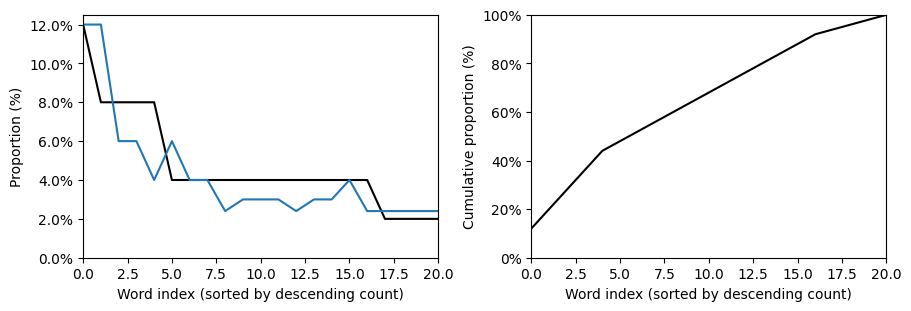

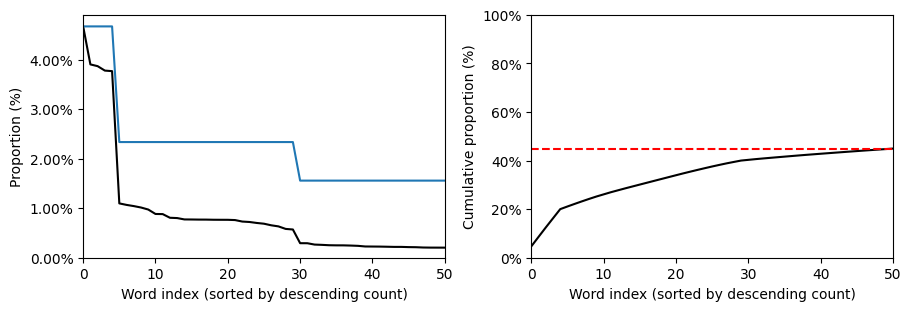

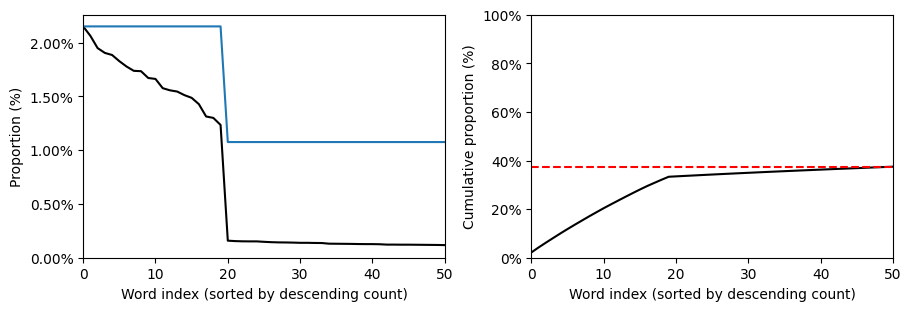

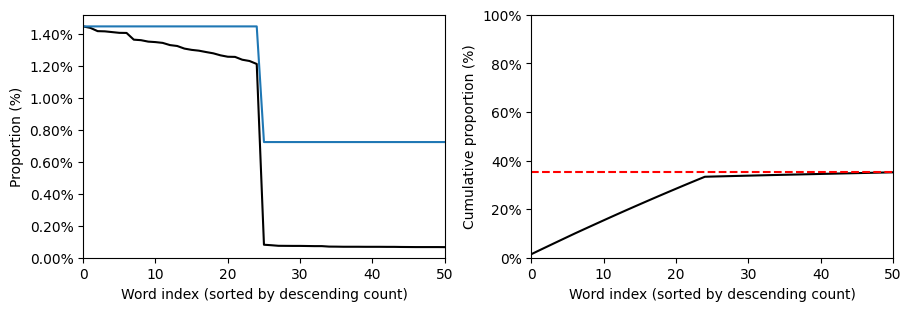

In [251]:
plot_wfdist(words_df2, limit = 50)
plot_wfdist(words_df5, limit = 50)
plot_wfdist(words_df20, limit = 50)
plot_wfdist(words_df25, limit = 50)

In [260]:

# get_max_nwords(n_obs, maxlen)
# get_memory_usage_MB(n_obs, n_cwords, n_iwords = None)


# words_df25#.set_index(words_df25["word"]).drop(["word"], axis = 1)

In [273]:
words_df20["len"] = words_df20["word"].apply(len)
vcs = words_df20["len"].value_counts().sort_index()
n_obs = vcs[1]

print(get_memory_usage_MB(n_obs, vcs[1] + vcs[2], vcs[1] + vcs[2] + vcs[3]))

28.081949


In [275]:
vcs

len
1      20
2     400
3    7896
Name: count, dtype: int64

In [302]:
def f_estimate(
	observation,
	*subwords
):
	word = "".join(subwords)
	count = count_appearences(observation, word)
	return count / (len(observation) - len(word) + 1)

def fhat(observation):
    def occ(word):
        count = count_appearences(observation, word)
        length = (len(observation) - len(word) + 1)
        return count / length
    return occ

maxlen = 5
words_df2 = get_most_common(sequence2, maxlen = maxlen)
words_df2["fhat"] = words_df2["word"].apply(fhat(sequence2))
words_df2

Keeping 100.00% of words accounts for 100.00% of counted substrings (with overlap)


,word,freq,cum_prop,fhat
0,b,30000,0.120005,0.600000
1,a,20000,0.200008,0.400000
2,ab,20000,0.280011,0.400008
3,ba,19999,0.360010,0.399988
4,bab,19999,0.440010,0.399996
5,bb,10000,0.480011,0.200004
6,aba,10000,0.520013,0.200008
7,abb,10000,0.560014,0.200008
8,babab,10000,0.600016,0.200016
9,abab,10000,0.640018,0.200012


# Final word construction

In [ ]:
import re

def count_appearences(
	observation,
	*subwords
) -> int:
	word = "".join(subwords)
	pattern = "(?=(" + word + "))"
	count = len(re.findall(pattern, observation))
	return count


def get_most_common(
    observation,
    maxlen,
    possible_observations = None
):
    if possible_observations is None:
        # Get alphabet by unique observations
        possible_observations = list(pd.Series(list(observation)).drop_duplicates().sort_values())

    # ctlen = len(observation) + 1
    
    words = ['']
    freqs = []
    lengs = []
    
    for wlen in range(1, maxlen + 1):
        # Save reference for which words already exist
        cur_nwords = len(words)

        # Generate all words of length wlen by extending the word list
        for idx, word in enumerate(words):
            # Iterate through words that existed at the start of first loop
            if idx >= cur_nwords:
                break
            
            for obs in possible_observations:
                # Get new word
                new_word = word + obs
                if new_word in words:
                    continue

                # Statistics
                prop = count_appearences(observation, new_word)
                leng = len(observation) + 1 - wlen
                # leng = len(observation) + 1 - len(new_word)

                # Keep # if relevant
                # if prop > 0:
                words.append(new_word)
                freqs.append(prop)
                lengs.append(leng)

        # Remove empty word
        try:
            words.remove('')
        except ValueError:
            pass
    
    wds = pd.DataFrame({
        "word": words,
        "freq": freqs,
        "leng": lengs,
    })
    wds["fhat"] = wds["freq"] / wds["leng"]
    wds = wds.sort_values(by = "freq", ascending = False).reset_index(drop = True)

    return wds

In [416]:
def get_dim(n_obs, l_chr, l_ind):
    return int((n_obs ** (l_chr + 1) - 1) *\
               (n_obs ** (l_ind + 1) - 1) /\
               ((n_obs - 1) ** 2))

def get_memory_usage_MB_new(
    n_obs,
    l_chr,
    l_ind
):
    n_chr = (n_obs ** (l_chr + 1) - 1) / (n_obs - 1)
    n_ind = (n_obs ** (l_ind + 1) - 1) / (n_obs - 1)
    
    def mat_memsize_bytes(n_rows, n_cols):
        # 8 bytes per entry
        # 128 bytes of machinery
        return 8 * n_rows * n_cols + 128
    
    # F_IJ and F_IzJ (for z in observations) => shape (n_words + 1) x (n_words + 1)
    mem_bigmats = (1 + n_obs) + mat_memsize_bytes(n_ind, n_chr)

    # F_0J and F_I0 => shape 1 x n_words, n_words x 1
    mem_rcvecs = mat_memsize_bytes(n_ind, 1) + mat_memsize_bytes(1, n_chr)

    # 1 MB = 10**6 bytes
    conv_fac = 10 ** 6
    
    return (mem_bigmats + mem_rcvecs) / conv_fac

def search_memlim(n_obs, max_mb: float = 50):
    mem = 0
    clen, ilen = 0, 0
    while True:
        clen += 1
        ilen += 1
        dim = get_dim(n_obs, clen, ilen)
        mem = get_memory_usage_MB_new(n_obs, clen, ilen)
        
        if mem > max_mb:
            clen -= 1
            ilen -= 1
            break
        else:
            print(f"{clen=} {ilen=} {mem=}")
    
    while True:
        clen += 1
        dim = get_dim(n_obs, clen, ilen)
        mem = get_memory_usage_MB_new(n_obs, clen, ilen)
        
        if mem > max_mb:
            clen -= 1
            break
        else:
            print(f"{clen=} {ilen=} {mem=}")
    return clen, ilen
        
clen, ilen = search_memlim(100, max_mb = 50)
print(f"chr words of length <= {clen}, "
      f"ind words of length <= {ilen}")

clen=1 ilen=1 mem=0.083709
clen=2 ilen=1 mem=8.243709
chr words of length <= 2, ind words of length <= 1


In [399]:
def construct_words(
    observation,
    maxlen,
    possible_observations = None
):
    if possible_observations is None:
        # Get alphabet by unique observations
        possible_observations = list(pd.Series(list(observation)).drop_duplicates().sort_values())

    # ctlen = len(observation) + 1
    
    words = ['']
    
    for wlen in range(1, maxlen + 1):
        # Save reference for which words already exist
        cur_nwords = len(words)

        # Generate all words of length wlen by extending the word list
        for idx, word in enumerate(words):
            # Iterate through words that existed at the start of first loop
            if idx >= cur_nwords:
                break
            
            for obs in possible_observations:
                # Get new word
                new_word = word + obs
                if new_word in words:
                    continue

                # Keep # if relevant
                # if prop > 0:
                words.append(new_word)

        # Remove empty word
        try:
            words.remove('')
        except ValueError:
            pass

    words_srs = pd.Series(words).apply(len)
    words_srs.index = words
    return words_srs

In [417]:
observation = sequence5
n_obs = len(list(pd.Series(list(observation)).drop_duplicates().sort_values()))
clen, ilen = search_memlim(n_obs, max_mb = 50)

print(f"{n_obs=} {clen=} {ilen=}")

cwords = construct_words(observation, maxlen = clen) # clen >= ilen by construction
iwords = cwords[cwords <= ilen]


def get_ciwords

clen=1 ilen=1 mem=0.000774
clen=2 ilen=2 mem=0.008574
clen=3 ilen=3 mem=0.197574
clen=4 ilen=4 mem=4.892574
clen=5 ilen=4 mem=24.442574
n_obs=5 clen=5 ilen=4


In [426]:
cwords

a        1
b        1
c        1
d        1
e        1
        ..
eeeea    5
eeeeb    5
eeeec    5
eeeed    5
eeeee    5
Length: 3905, dtype: int64

In [427]:
iwords

a       1
b       1
c       1
d       1
e       1
       ..
eeea    4
eeeb    4
eeec    4
eeed    4
eeee    4
Length: 780, dtype: int64